In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from collections import defaultdict, Counter
from tools.record_tools import complete_records

In [2]:
sns.set()

In [3]:
df = pd.read_csv('output_data/MPD_export_1846_1920_JISC.csv', index_col=0)
#df_geocoded = pd.read_csv('output_data/MPD_export_1846_1920_geo_coded.csv', index_col=0)
#print(df_jisc.shape,df_geocoded.shape)

In [4]:
df.head(3)

,index,id,S-TITLE,S-POL,CATEGORY,DISTRICT,DISTRICT_PUB,COUNTY,S-PRICE,D-EST,D-PUB,E-LOC,E-ORG,E-PER,S-TITLE-ALT,TEXT,DISTRICT_DESCRIPTION,year,chain_id,JISC
0,0,MPD_1846_0,MORNING ADVERTISER .,liberal,london,london,london,london,5d,"February 8 , 1793",Daily,NaN,NaN,David,NaN,"MORNING ADVERTISER . Daily , Price 5d . Establ...",London,1846,CID_004463,NaN
1,1,MPD_1846_1,MORNING CHRONILE .,moderate;,london,london,london,london,5d,1770,Daily,",<SEP>332",NaN,Henry<SEP>William Wills,NaN,"MORNING CHRONILE . Daily , Price 5d . Establis...",London,1846,CID_004464,13915254.0
2,2,MPD_1846_2,DAILY NEWS .,liberal; democratic,london,london,london,london,5d,"January 21 , 1846",Daily,to . The leading minds in have not re ceived,the,particular France,NaN,"DAILY NEWS . Daily , Price 5d . Established Ja...",London,1846,NaN,NaN


In [5]:
#df = df.merge(df_geocoded[['id','wikidata_id','latitude','longitude','hcounties']], right_on='id',left_on='id',how='left')
#df.shape

In [6]:
df = complete_records(df,'S-POL')

In [7]:
convert_price = {'1d':1, '2d':2 ,'½ d':.5,'3d':3,
    '1 ½ d':1.5, '6d':6,'4d':4, 
    '5d':5, '3 ½ d':3.5, '4 ½ d':4.5,
    '2 ½ d':2.5, '1s':12, 'Gratis':.0, 
    '9d':9, '7d':7, '8d':8, 'gratis':0, 
    '5s':60, '21s':252, '10s':120, '20s':240, 
    '2s':24, '8s':96, '£ 3 3s':756, '12s':144, 
    '1':1,'One Halfpenny':.5, '1 ½':1.5, 
    '26s':312, '7s':84,'½<CON>d':.5, 
    '2':2,'£ 1 12s':384,'24s':288, 
    '3 ½':3.5,'15s':189, 'Halfpenny':.5,
    '£ 1 19s':468,'40s':480,'1 ½ 4':1.5,
    '13s':156, '£ 1 10s':360, '6':6, 
    ' ½ d':.5, '6s':72,'Gra':0, 
    '42s':504,'5 ½ d':5.5,'One Penny':1,
    'Sixpence':72, '£ 2 2s':504, '£2 ':480,
    '4s':48,'£ 1 5s':252,'£ 2 16s':672 ,
    '4 ½':4.5,'3s':36}


df['first_price'] = df['S-PRICE'].apply(lambda x: x.split('<SEP>')[0] if isinstance(x,str) else x)
df['first_price'] = df['first_price'].apply(lambda x: convert_price.get(x,None))
df = complete_records(df,'first_price')

def force_int(x):
    try:
        return int(x)
    except:
        return x

df['first_price_int'] = df.first_price.apply(force_int)


In [8]:
df_prov = df[df.CATEGORY.isin(['provincial','welsh','scottish'])]


In [9]:
df_prov.loc[df_prov['first_price_int'] > 10.0,'first_price_int'] = 10.0
selected_prices = list(df_prov.first_price_int.value_counts().index)




/data/anaconda/envs/py37torch/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


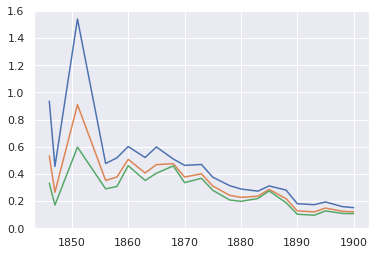

In [21]:


def price_distribution_by_year(df,year,prices,jisc=False, smoothing=0.001):
    if jisc:
        df_year = df[(df.year==year) & (~df.JISC.isnull())]
    else:
        df_year = df[df.year==year]
    price2counts = dict(df_year.first_price_int.value_counts())

    price_probs = [(price2counts.get(i,.0) + smoothing) / (sum(price2counts.values()) + len(price2counts)*smoothing) 
                            for i in prices]

    return price_probs, df_year.first_price_int.mean(),df_year.first_price_int.std()
results = {}
results_avg = {}

for sm in [.00001,0.001,0.01]:
    for year in df_prov.year.unique():
        if year > 1900: continue
        sample = price_distribution_by_year(df_prov,year,selected_prices, jisc=True,smoothing=sm)
        population = price_distribution_by_year(df_prov,year,selected_prices, jisc=False,smoothing=sm)
        results[year] = entropy(population[0], sample[0])
        results_avg[year] = [population[1],population[2],sample[1],sample[2]]
    pd.Series(results).plot(ylim=(0,1.6))

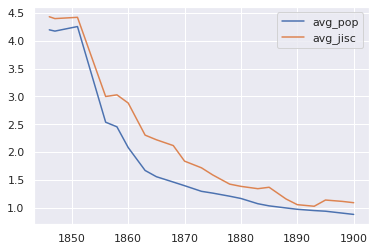

In [43]:
df_price_result = pd.DataFrame.from_dict(results_avg,orient='index',columns=['avg_pop','std_pop','avg_jisc','std_jisc'])
df_price_result[['avg_pop','avg_jisc']].plot()

In [30]:
df_price_result[['std_pop','std_jisc']]

,std_pop,std_jisc
1846,0.911238,0.678911
1847,1.010119,0.723974
1851,0.931061,0.643309
1856,1.220776,0.829156
1858,1.231622,0.936961
1860,1.193104,0.913359
1863,0.980016,0.920231
1865,0.938284,0.897969
1868,0.912611,1.037617
1870,0.959941,0.897946


In [41]:
fig, ax = plt.subplots()
df_price_result.plot(kind='bar',yerr=['std_pop','std_jisc'], ax=ax, capsize=4, rot=90)


ConversionError: Failed to convert value(s) to axis units: array(['std_pop', 'std_jisc'], dtype='<U8')

In [42]:
fig, ax = plt.subplots()
df_price_result.plot(kind='bar',yerr=['std_pop'], ax=ax, capsize=4, rot=90)
df_price_result[['std_jisc','avg_jisc']].plot(kind='bar',yerr='std_jisc', ax=ax, capsize=4, rot=90)

ConversionError: Failed to convert value(s) to axis units: array(['std_pop'], dtype='<U7')

In [12]:
counties = df_prov.COUNTY.value_counts()
selected_counties = list(counties[counties> 100].index)
df_prov.loc[~df_prov['COUNTY'].isin(selected_counties),'COUNTY'] = 'other'
selected_counties.append('other')


/data/anaconda/envs/py37torch/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
#df_prov.COUNTY.value_counts()

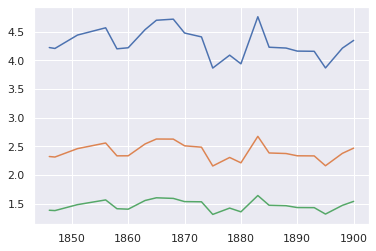

In [20]:

def county_distribution_by_year(df,year,prices,jisc=False, smoothing=0.001):
    if jisc:
        df_year = df[(df.year==year) & (~df.JISC.isnull())]
    else:
        df_year = df[df.year==year]
    county2counts = dict(df_year.COUNTY.value_counts())
    county_probs = [(county2counts.get(i,.0) + smoothing) / (sum(county2counts.values()) + len(county2counts)*smoothing) 
                for i in prices]

    
    return county_probs
results = {}
for sm in [0.00001,0.001,0.01]:
    for year in df_prov.year.unique():
        if year > 1900: continue
        sample = county_distribution_by_year(df_prov,year,selected_counties,jisc=True,smoothing=sm)
        population = county_distribution_by_year(df_prov,year,selected_counties,jisc=False,smoothing=sm)
        results[year] = entropy(population,sample)

    pd.Series(results).plot()

In [113]:

pol_dict = dict(Counter(i.strip() for l in df_prov['S-POL'] for i in str(l).split(';')).most_common()[:10])
selected_pol = list(pd.Series(pol_dict,index=pol_dict.keys()).index)
selected_pol



TypeError: list() takes no keyword arguments

['yorkshire',
 'lancashire',
 'kent',
 'devonshire',
 'sussex',
 'somersetshire',
 'warwickshire',
 'staffordshire',
 'surrey',
 'gloucestershire',
 'essex',
 'lanarkshire',
 'cheshire',
 'hampshire',
 'lincolnshire',
 'derbyshire',
 'glamorganshire',
 'hertfordshire',
 'durham',
 'northumberland',
 'edinburghshire',
 'worcestershire',
 'norfolk',
 'cumberland',
 'suffolk',
 'nottinghamshire',
 'oxfordshire',
 'cornwall',
 'dorsetshire',
 'middlesex',
 'wiltshire',
 'cambridgeshire',
 'leicestershire',
 'forfarshire',
 'northamptonshire',
 'monmouthshire',
 'berkshire',
 'fifeshire',
 'aberdeenshire',
 'ayrshire',
 'carnarvonshire',
 'bedfordshire',
 'shropshire',
 'buckinghamshire',
 'perthshire',
 'stirlingshire',
 'denbighshire',
 'isle of wight',
 'renfrewshire',
 'pembrokeshire',
 'dumfriesshire',
 'carmarthenshire',
 'roxburghshire',
 'argyllshire',
 'westmorland',
 'flintshire',
 'huntingdonshire',
 'dumbartonshire']

In [82]:
df_prov.loc[~df.COUNTY.isin(selected_counties),'COUNTY'] = 'other'

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
def compute_typicality(selected_county,df,jisc=True):

    def typicality_scores(selected_sample,df_sel):
        results = []
        
        for i,row in selected_sample.iterrows():
            pol = row['S-POL']    
            price = row['first_price_int']
            if pol is np.nan or price is np.nan: continue


            p_a = df_sel[df_sel['S-POL']==pol].shape[0] / df_sel.shape[0]
            p_a_b_nom = df_sel[(df_sel['S-POL']==pol) & (df_sel['first_price_int']==price)].shape[0] 
            p_a_b_denom = df_sel[df_sel['S-POL']==pol].shape[0] 
            p_a_b =  p_a_b_nom / p_a_b_denom
            results.append(p_a*p_a_b)

        return results


    results_general = [] #defaultdict(list)
    results_yearly =  defaultdict(list)

    for year in df.year.unique():

        if year > 1900: continue
        df_sel_county = df[(df.COUNTY==selected_county) & (df.year == year)]
        if df_sel_county.shape[0] <= 0: continue
        
        sample = df_sel_county[~df.JISC.isnull()]
        if sample.shape[0] <= 0: continue
        sample_typ = typicality_scores(sample,df_sel_county)
        for _ in range(100):
            random_sample = df_sel_county.sample(sample.shape[0])
            random_sample_typ = typicality_scores(random_sample,df_sel_county)
            results_general.append(np.nanmean(sample_typ) - np.nanmean(random_sample_typ))
            results_yearly[year].append(np.nanmean(sample_typ) - np.nanmean(random_sample_typ))
        
    results_yearly = {y:np.nanmean(scores) for y, scores in results_yearly.items()}
    return results_general,results_yearly
    


/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


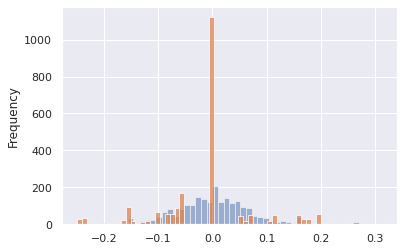

In [24]:

pd.Series(compute_typicality('lancashire',df)[0]).plot(kind='hist',alpha=.5,bins=50)
pd.Series(compute_typicality('oxfordshire',df)[0]).plot(kind='hist',alpha=.75,bins=50)




/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


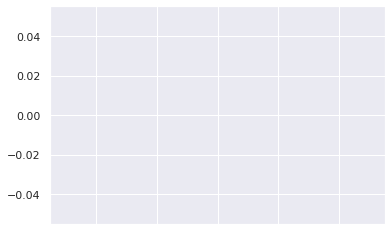

In [18]:
pd.Series(compute_typicality('bedfordshire',df)[1]).plot()
#pd.Series(compute_typicality('devonshire',df)[1]).plot()

In [133]:
compute_typicality('essex',df)[1]

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


{1846: -0.33333333333333337,
 1847: -0.33333333333333337,
 1851: -0.33333333333333337,
 1856: 0.0,
 1858: 0.0,
 1860: 0.0375,
 1863: -0.009090909090909085,
 1865: -0.14285714285714285,
 1868: -0.11578947368421053,
 1870: -0.11000000000000001,
 1873: -0.14444444444444443,
 1875: -0.2175925925925926,
 1878: -0.14800000000000002,
 1880: -0.14615384615384616,
 1883: -0.14838709677419354,
 1885: -0.2451612903225806,
 1888: -0.13194444444444448,
 1890: -0.09999999999999999,
 1893: 0.012500000000000006,
 1895: -0.04521276595744679,
 1898: -0.13114754098360656,
 1900: -0.03571428571428572}